In [1]:
import tensorflow as tf
from tensorflow.keras import layers, losses, metrics, optimizers, callbacks
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from imblearn.metrics import classification_report_imbalanced

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import seaborn as sns
import matplotlib.pyplot as plt
import requests

In [40]:
df1 = (
    pd.read_csv("./DryBeanDataset/Dry_Bean_Dataset.csv")
    .sample(frac=1)
    .reset_index(drop=True)
)
df = pd.read_csv("./selected_features/Anova.csv")

In [26]:
df.head(10)

,Area,Perimeter,MajorAxisLength,AspectRation,ConvexArea,EquivDiameter,Compactness,ShapeFactor2,labels
0,35280,717.703,264.995250,1.558472,35772,211.943132,0.799800,0.001896,3
1,83296,1142.638,446.765889,1.869209,84270,325.662035,0.728932,0.000934,2
2,35594,689.634,254.572928,1.426644,35966,212.884213,0.836241,0.002157,3
3,52710,872.700,326.039383,1.572036,53280,259.060720,0.794569,0.001521,6
4,62855,1004.759,413.879306,2.130112,63781,282.894807,0.683520,0.000887,4
5,36112,723.077,225.328776,1.100957,36709,214.427672,0.951621,0.003156,5
6,59442,975.979,402.887444,2.118794,60289,275.107079,0.682839,0.000909,4
7,58931,957.164,388.354344,2.001383,59526,273.922032,0.705340,0.001006,4
8,34010,681.989,257.829640,1.528818,34410,208.093433,0.807097,0.001984,3
9,27280,603.203,223.021086,1.428199,27550,186.370531,0.835663,0.002459,3


In [27]:
net = tf.keras.Sequential(
    [
        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),
        layers.Dense(7),
    ]
)

In [29]:
X = df.drop(columns=["labels"]).values
# y = df.Class.astype("category").cat.codes.values
y = df.labels.values

In [30]:
# X, y = SMOTE().fit_resample(X, y)

In [31]:
# scaling the the data for training!
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

X_train = scaler.fit_transform(X_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [32]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(16)

In [33]:
net.compile(
    optimizer=optimizers.Adam(learning_rate=3e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

In [34]:
history = net.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        callbacks.ModelCheckpoint("models/4", save_best_only=True, verbose=3),
    ],
)

Epoch 1/20
231/231 [==============================] - ETA: 0s - loss: 0.6025 - sparse_categorical_accuracy: 0.8157
Epoch 00001: val_loss improved from inf to 0.36866, saving model to models\4
INFO:tensorflow:Assets written to: models\4\assets
231/231 [==============================] - 7s 26ms/step - loss: 0.6025 - sparse_categorical_accuracy: 0.8157 - val_loss: 0.3687 - val_sparse_categorical_accuracy: 0.8845
Epoch 2/20
230/231 [============================>.] - ETA: 0s - loss: 0.3111 - sparse_categorical_accuracy: 0.8895
Epoch 00002: val_loss improved from 0.36866 to 0.30920, saving model to models\4
INFO:tensorflow:Assets written to: models\4\assets
231/231 [==============================] - 2s 10ms/step - loss: 0.3108 - sparse_categorical_accuracy: 0.8897 - val_loss: 0.3092 - val_sparse_categorical_accuracy: 0.8955
Epoch 3/20
223/231 [===========================>..] - ETA: 0s - loss: 0.2872 - sparse_categorical_accuracy: 0.8945
Epoch 00003: val_loss improved from 0.30920 to 0.28359,

INFO:tensorflow:Assets written to: models\4\assets
231/231 [==============================] - 3s 15ms/step - loss: 0.2385 - sparse_categorical_accuracy: 0.9112 - val_loss: 0.2421 - val_sparse_categorical_accuracy: 0.9113


In [35]:
# Transforming the test set

X_test = scaler.transform(X_test)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)

In [36]:
net.evaluate(test_ds)

205/205 [==============================] - 1s 6ms/step - loss: 0.2722 - sparse_categorical_accuracy: 0.8999


[0.2722165286540985, 0.8999390006065369]

In [37]:
preds = net(X_test)
preds = tf.argmax(preds, axis=1)

In [41]:
cf = confusion_matrix(y_test, preds)

classes = df1.Class.astype("category").cat.categories.tolist()
print(classification_report_imbalanced(y_test, preds, target_names=classes))

                   pre       rec       spe        f1       geo       iba       sup

   BARBUNYA       0.96      0.80      1.00      0.87      0.89      0.78       335
     BOMBAY       1.00      1.00      1.00      1.00      1.00      1.00         3
       CALI       0.87      0.95      0.98      0.91      0.96      0.93       416
   DERMASON       0.89      0.92      0.96      0.91      0.94      0.88       854
      HOROZ       0.98      0.89      1.00      0.93      0.94      0.88       508
      SEKER       0.95      0.94      0.99      0.95      0.97      0.93       513
       SIRA       0.81      0.86      0.95      0.84      0.91      0.81       649

avg / total       0.90      0.90      0.98      0.90      0.94      0.87      3278



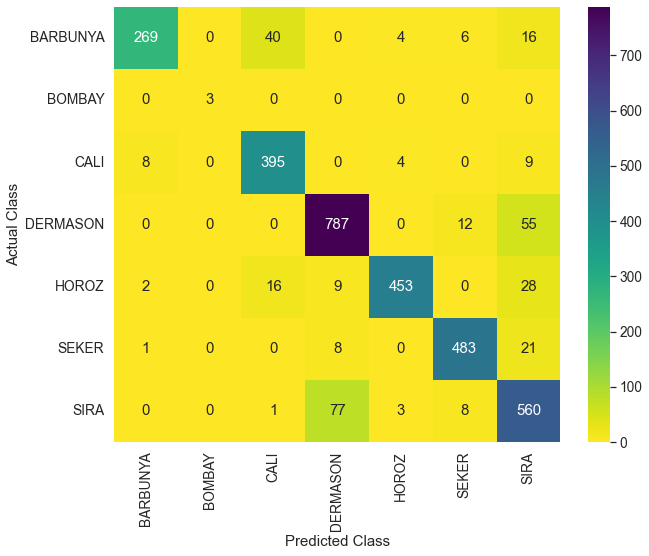

In [43]:
classes = df1.Class.astype("category").cat.categories.tolist()
sns.set(rc={"figure.figsize": (10, 8)}, font_scale=1.25)
ax = sns.heatmap(
    cf, annot=True, xticklabels=classes, yticklabels=classes, fmt="d", cmap="viridis_r"
)
ax.set_ylabel("Actual Class")
_ = ax.set_xlabel("Predicted Class")

## Testing on one example

In [23]:
sample = X_test[100]
sample, y_test[100]

(array([7.05730000e+04, 1.04901600e+03, 3.94676397e+02, 2.28370126e+02,
        1.72823129e+00, 8.15592825e-01, 7.17450000e+04, 2.99760462e+02,
        6.72636294e-01, 9.83664367e-01, 8.05905684e-01, 7.59509471e-01,
        5.59245600e-03, 1.14792900e-03, 5.76854637e-01, 9.96938232e-01]),
 0)

In [24]:
X_test_scaled = scaler.transform(X_test)

In [18]:
def predict(feats):
    idx2class = {
        0: "BARBUNYA",
        1: "BOMBAY",
        2: "CALI",
        3: "DERMASON",
        4: "HOROZ",
        5: "SEKER",
        6: "SIRA",
    }

    payload = {"instances": [feats.tolist()]}

    res = requests.post(
        url="http://localhost:8605/v1/models/dry_bean_model:predict", json=payload
    )

    preds = res.json()
    preds = preds["predictions"]
    idx = tf.argmax(preds, axis=1)

    print(f"The predicted class is: {idx2class[idx.numpy()[0]]}")

In [22]:
predict(X_test_scaled[101])

The predicted class is: DERMASON
